In [5]:
%pip install pandas numpy matplotlib scikit-learn scikit-optimize -q
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Attempt to load the data generated by running data.ipynb
try:
    pre_race_data = pd.read_csv('data/race_data.csv')
    print("Data loaded successfully.")
    display(pre_race_data.head())
except FileNotFoundError:
    print("Error: The file 'race_data.csv' does not exist.")
    print("First you need to run data.ipynb.")
    pre_race_data = None
    exit()

Data loaded successfully.


,driver_number,fastest_lap_time,fastest_lap_tyre_age,avg_lap_time,best_s1,best_s2,best_s3,avg_s1,avg_s2,avg_s3,...,fastest_lap_compound_MEDIUM,fastest_lap_compound_SOFT,fastest_lap_compound_WET,ran_HARD,ran_MEDIUM,ran_SOFT,ran_INTERMEDIATE,ran_WET,quali_position,race_position
0,77,91.793,0,111.004467,29.406,39.437,22.950,36.106111,46.795244,28.103111,...,False,True,False,False,True,True,False,False,12.0,8.0
1,4,91.570,0,110.083827,29.307,39.341,22.922,35.623385,46.888462,27.571981,...,False,True,False,False,True,True,False,False,11.0,17.0
2,24,91.586,0,111.504317,29.310,39.398,22.878,36.527976,46.677390,28.298951,...,False,True,False,False,True,True,False,False,13.0,16.0
3,11,91.078,0,108.753617,29.104,39.082,22.892,35.550915,46.188319,27.014383,...,False,True,False,True,True,True,False,False,2.0,2.0
4,21,92.605,0,113.304534,29.583,39.898,23.124,36.059897,48.889362,28.355276,...,False,True,False,False,True,True,False,False,19.0,14.0


In [7]:
# Drop high cardinality feature 'driver_number'
pre_race_data = pre_race_data.drop(columns=['driver_number'], errors='ignore')
print("High cardinality feature 'driver_number' dropped.")

High cardinality feature 'driver_number' dropped.


## Model Development

Starting Bayesian optimization...

Best parameters found:
max_depth: 5
max_features: 0.6294714320408507
min_samples_leaf: 10
min_samples_split: 2
n_estimators: 1000

Model Performance:
Mean Squared Error: 18.6696
R² Score: 0.4594


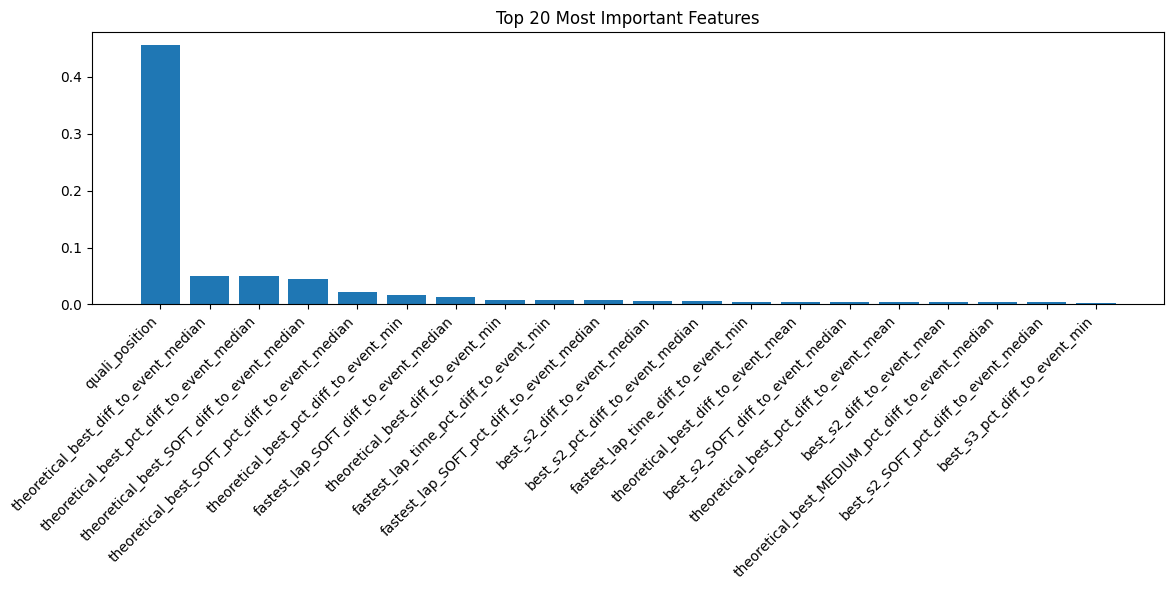

In [8]:
# Separate features and target
y = pre_race_data['race_position']
X = pre_race_data.drop('race_position', axis=1)

# Split the data into train, test, and eval sets (70:15:15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_test, X_eval, y_test, y_eval = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% test, 15% eval

# Define the search space for hyperparameters
search_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.1, 1.0)
}

# Create base random forest model
rf_model = RandomForestRegressor(random_state=42)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=rf_model,
    search_spaces=search_space,
    n_iter=50,  
    cv=5,  
    n_jobs=-1, 
    random_state=42,
    scoring='neg_mean_squared_error'
)

# Fit the model
print("Starting Bayesian optimization...")
bayes_search.fit(X_train, y_train)

# Get the best parameters and model
print("\nBest parameters found:")
for param, value in bayes_search.best_params_.items():
    print(f"{param}: {value}")

# Get the best model
best_rf_model = bayes_search.best_estimator_

# Make predictions on test set
y_pred = best_rf_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

In [9]:
# Define the model export path
model_export_path = 'models/race'
os.makedirs(model_export_path, exist_ok=True)

# Export the model as a .pkl file
model_filename = 'race_rf_model.pkl'
joblib.dump(best_rf_model, os.path.join(model_export_path, model_filename))
print(f"Model exported to {os.path.join(model_export_path, model_filename)}")

Model exported to models/race\race_rf_model.pkl


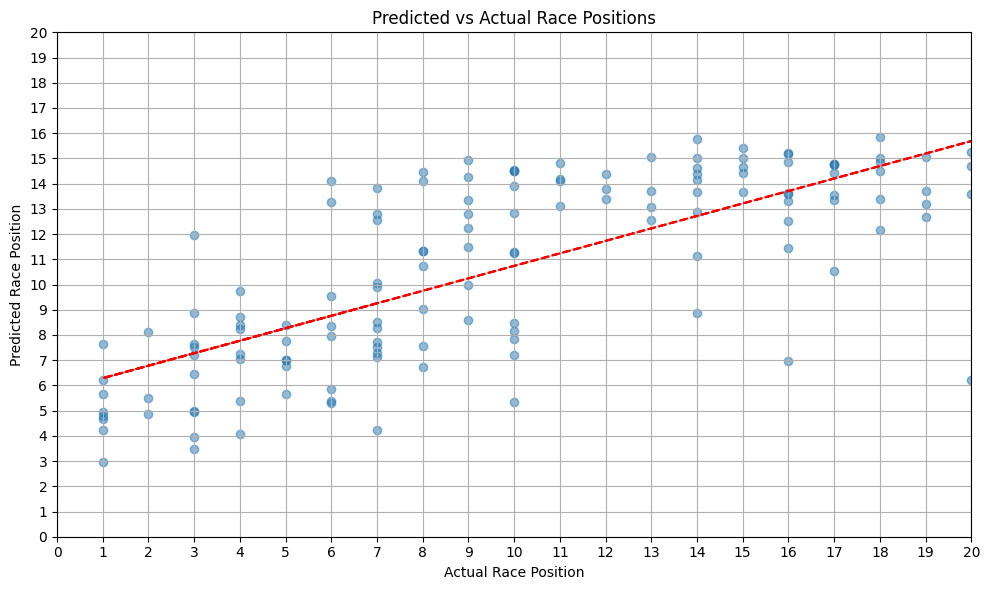

In [10]:
# Make predictions on the evaluation set
y_eval_pred = best_rf_model.predict(X_eval)

# Plot the predicted vs actual race positions
plt.figure(figsize=(10, 6))
plt.scatter(y_eval, y_eval_pred, alpha=0.5)
plt.xlabel('Actual Race Position')
plt.ylabel('Predicted Race Position')
plt.title('Predicted vs Actual Race Positions')

# Set x and y limits
plt.xlim(0, 20)
plt.ylim(0, 20)

# Set ticks for both axes
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(0, 21, 1))

# Add grid
plt.grid()

# Add line of best fit
plt.plot(y_eval, np.poly1d(np.polyfit(y_eval, y_eval_pred, 1))(y_eval), color='red', linestyle='--')

plt.tight_layout()
plt.show()


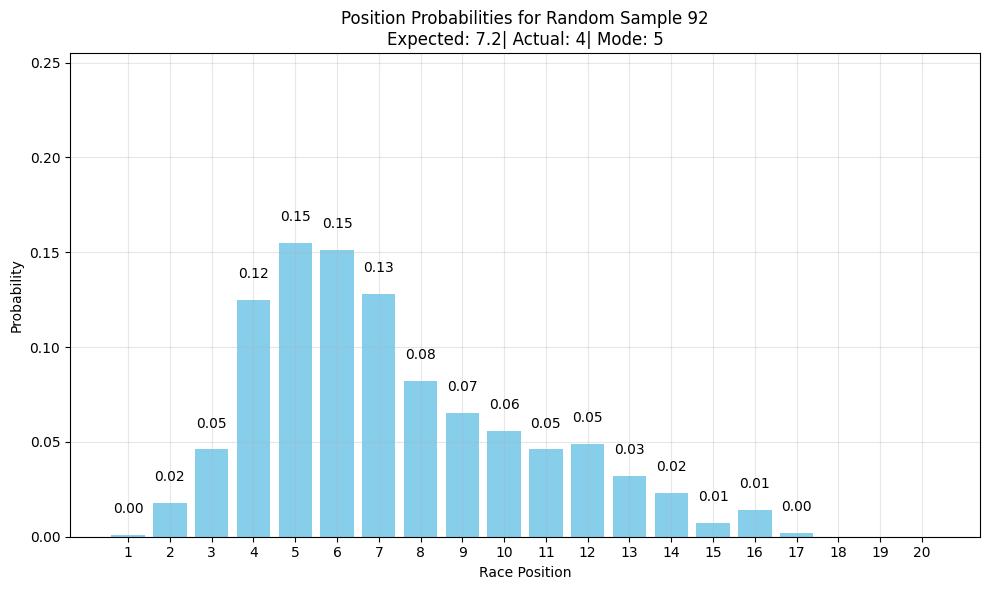

In [11]:
# Select an evaluation sample (random sample)
sample_index = np.random.randint(0, len(X_eval))  # Randomly select a sample to analyze
sample_data = X_eval.iloc[[sample_index]]
actual_position = y_eval.iloc[sample_index]

# Get the predicted value for this sample using the regression model
sample_prediction = best_rf_model.predict(sample_data)[0]

# Step 1: Get predictions from each individual tree
tree_predictions = [tree.predict(sample_data.values)[0] for tree in best_rf_model.estimators_]

# Step 2: Round predictions to nearest integer and clip to [1, 20]
tree_positions = np.clip(np.round(tree_predictions), 1, 20).astype(int)

# Step 3: Compute probabilities as the proportion of trees predicting each position
positions = np.arange(1, 21)  # Positions 1 to 20
counts = np.bincount(tree_positions, minlength=21)[1:21]  # Count occurrences, ignore index 0
probabilities = counts / len(tree_predictions)  # Normalize to get probabilities

# Create a bar plot showing the probability for each race position
plt.figure(figsize=(10, 6))
plt.bar(positions, probabilities, color='skyblue')
plt.xlabel("Race Position")
plt.ylabel("Probability")
plt.title(f"Position Probabilities for Random Sample {sample_index}\nExpected: {sample_prediction:.1f}| Actual: {actual_position:.0f}| Mode: {positions[np.argmax(probabilities)]}")
plt.xticks(positions)

# Annotate each bar with its probability value
for pos, prob in zip(positions, probabilities):
    if prob > 0:  # Only annotate non-zero probabilities for clarity
        plt.text(pos, prob + 0.01, f"{prob:.2f}", ha='center', va='bottom')

plt.ylim(0, max(probabilities) + 0.1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

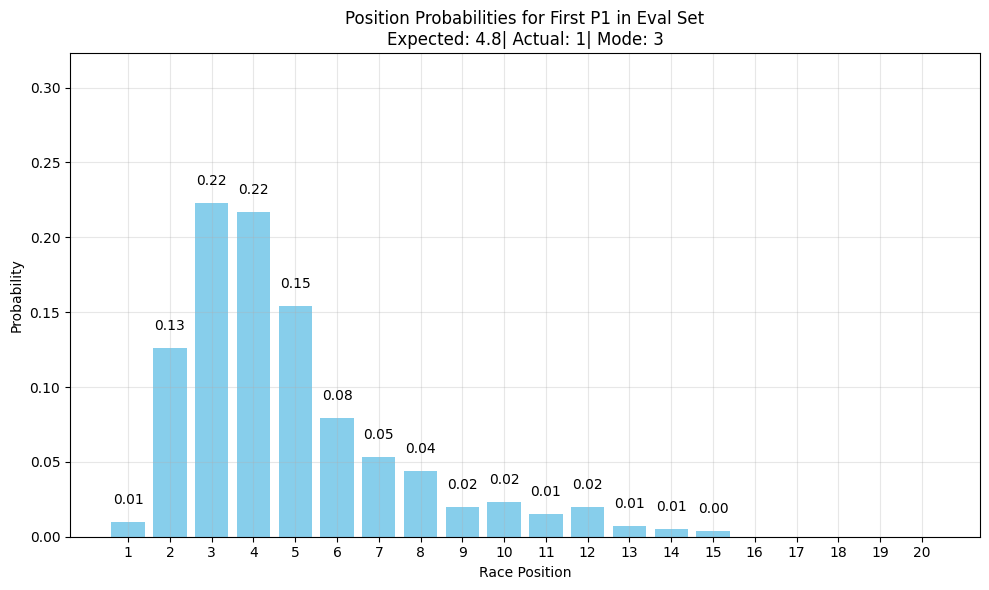

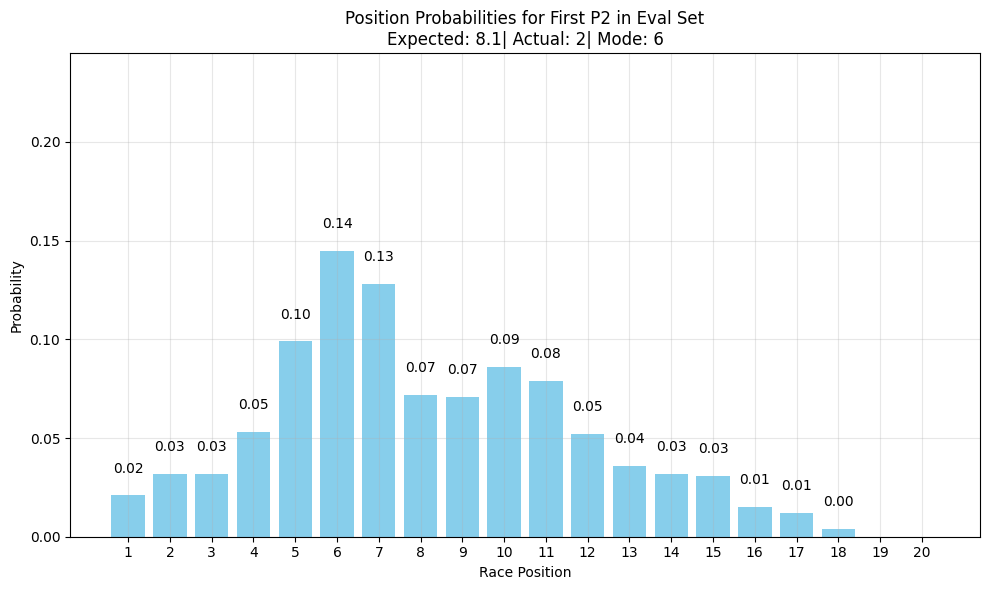

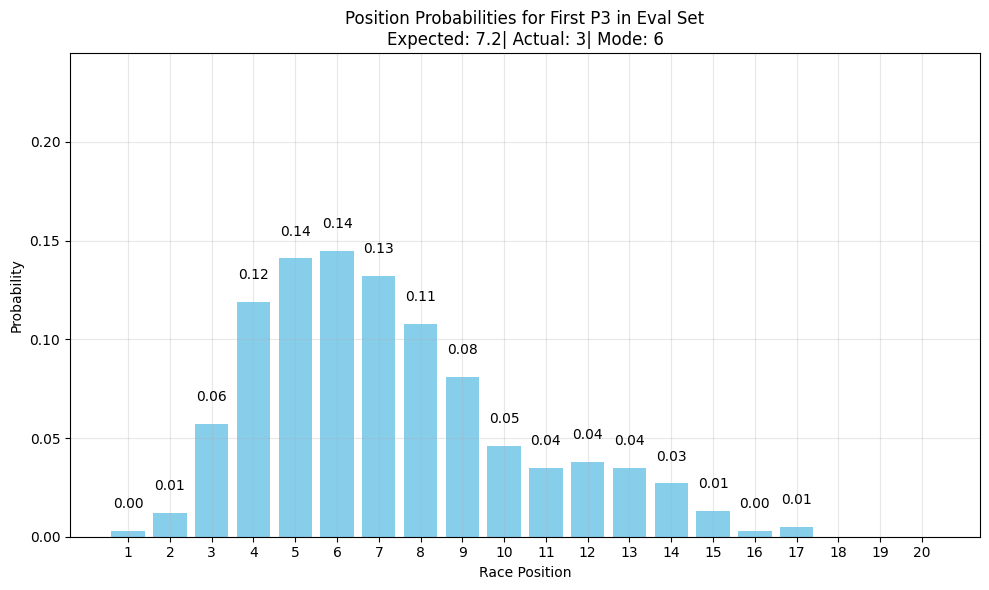

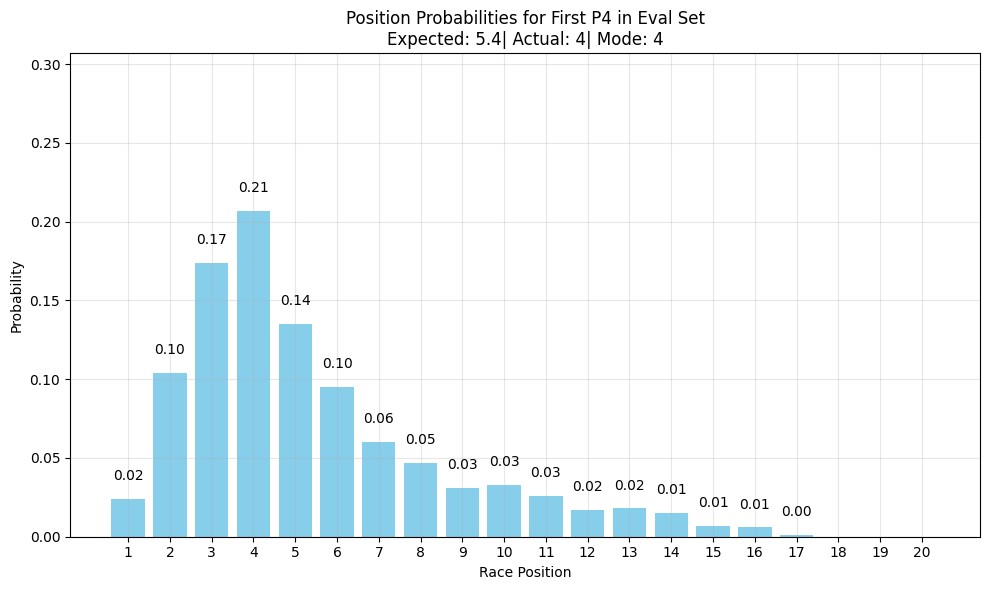

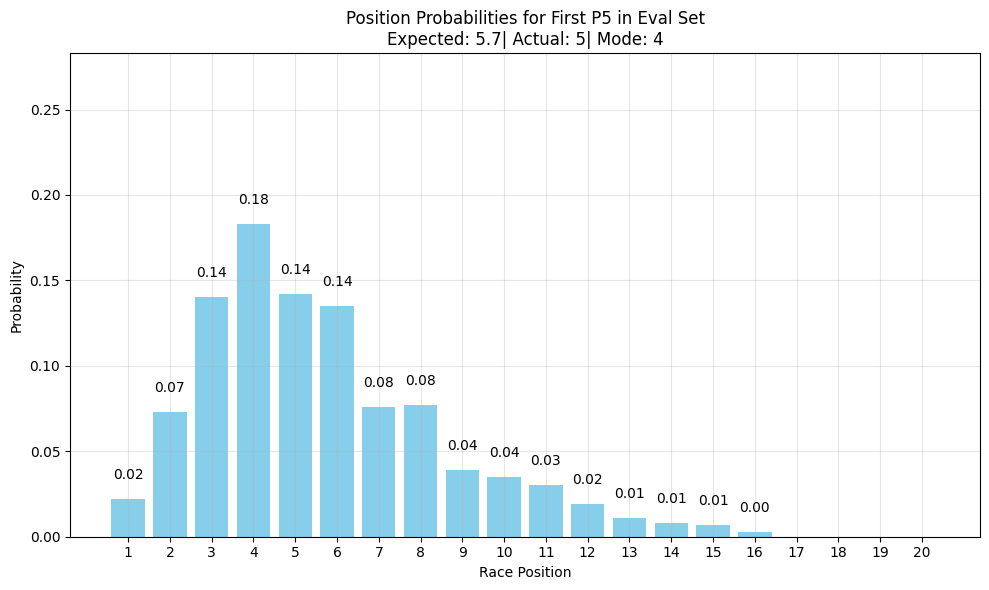

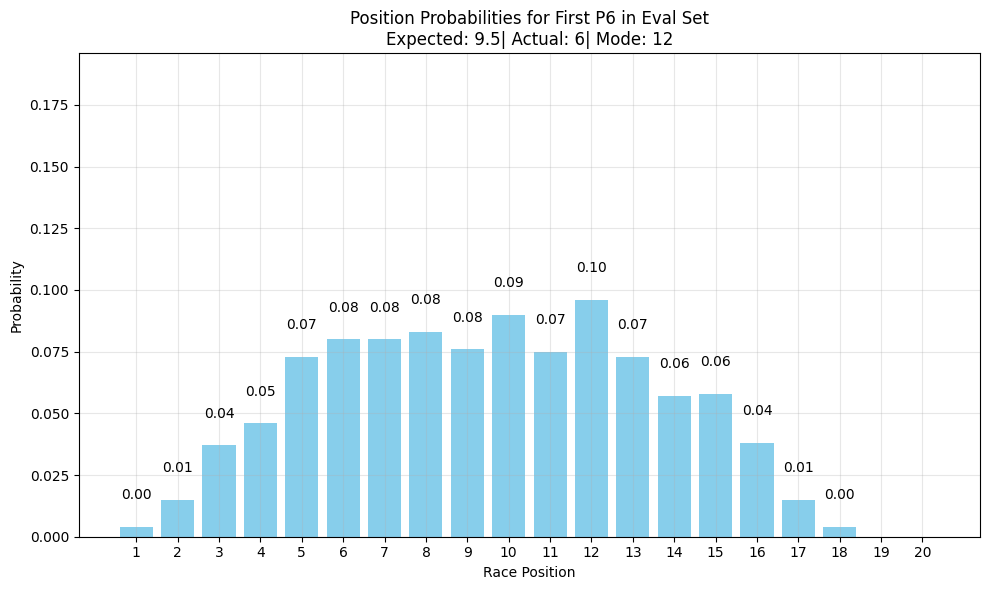

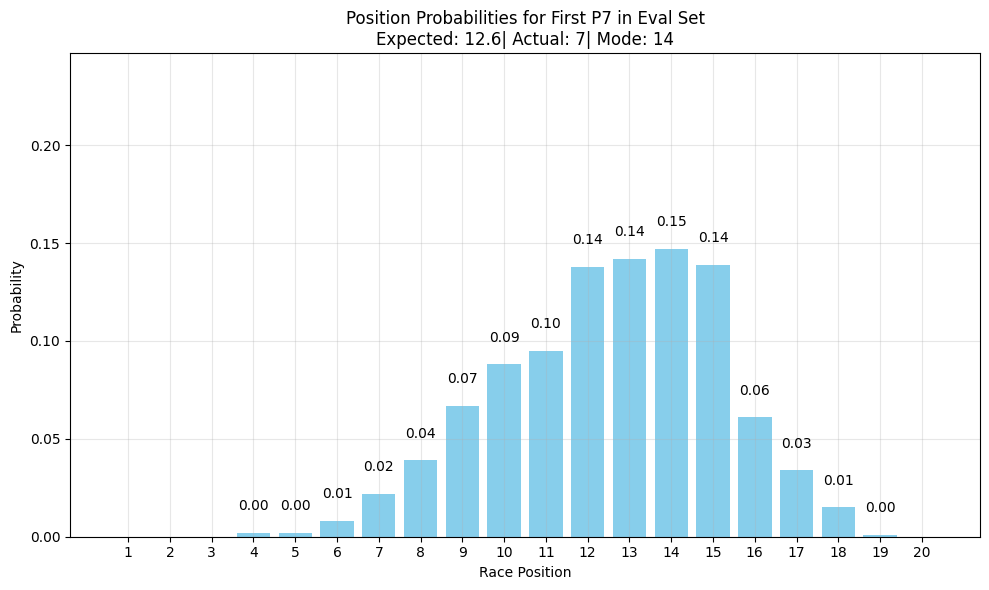

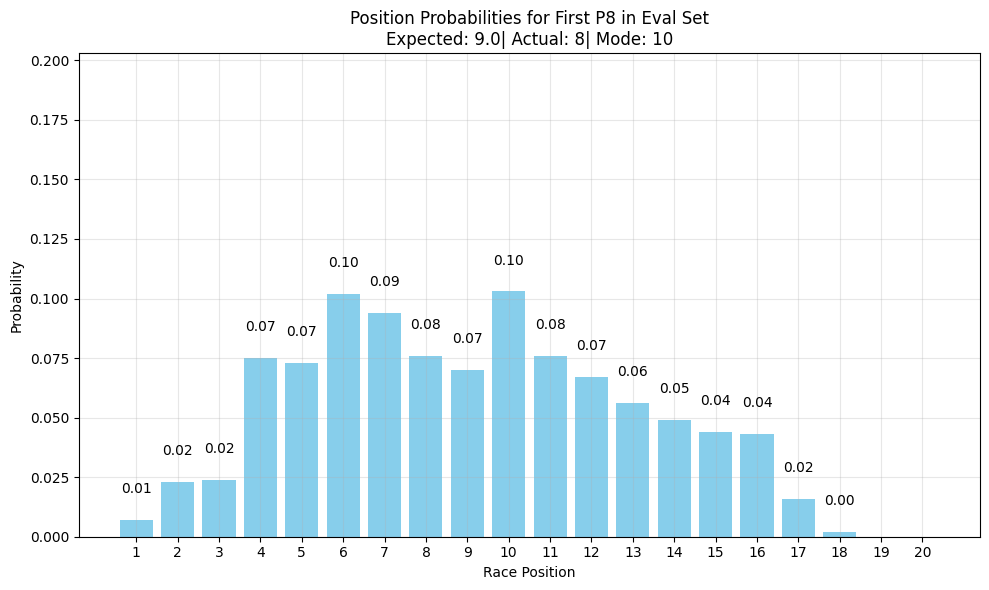

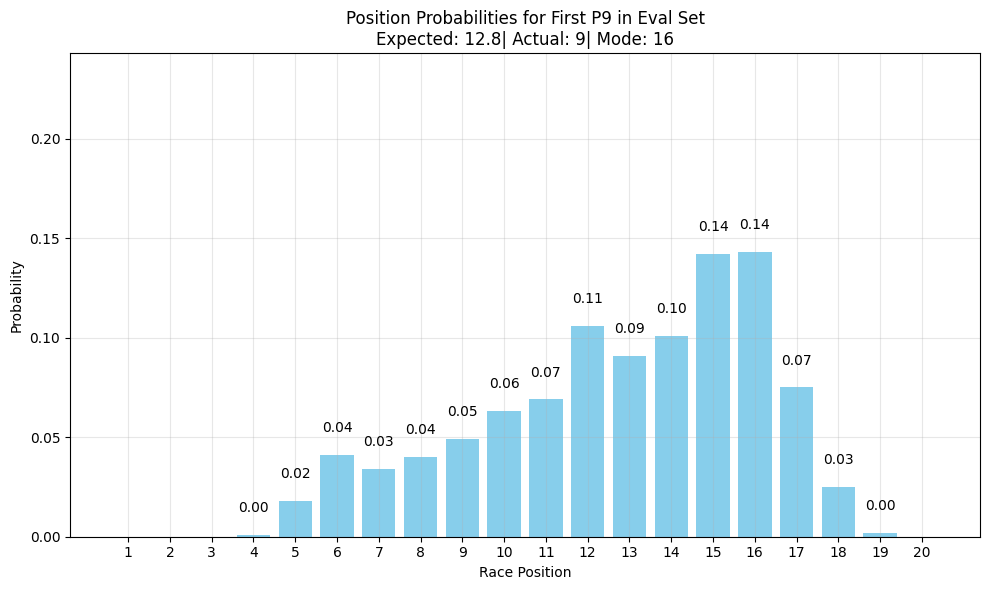

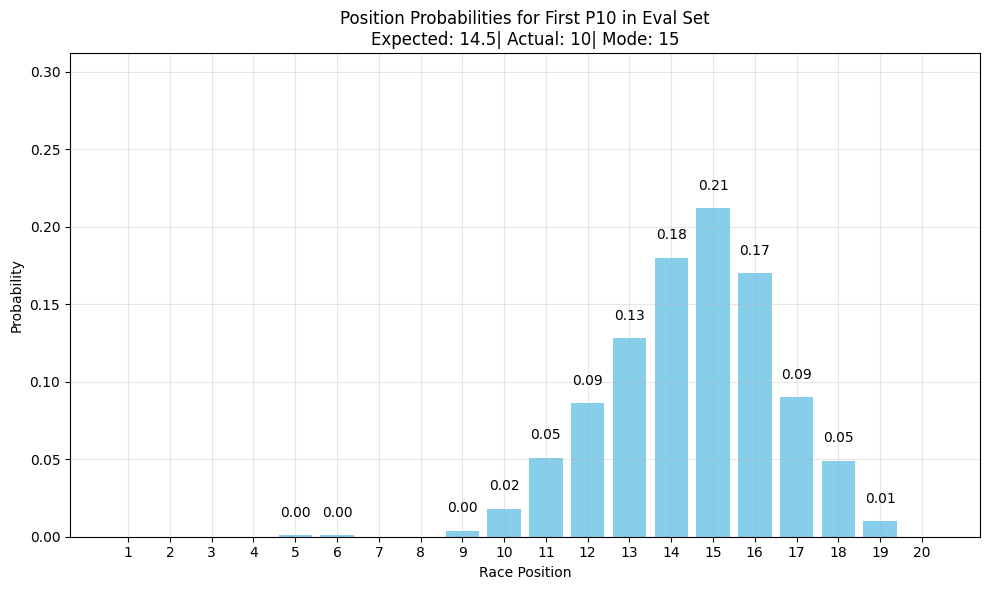

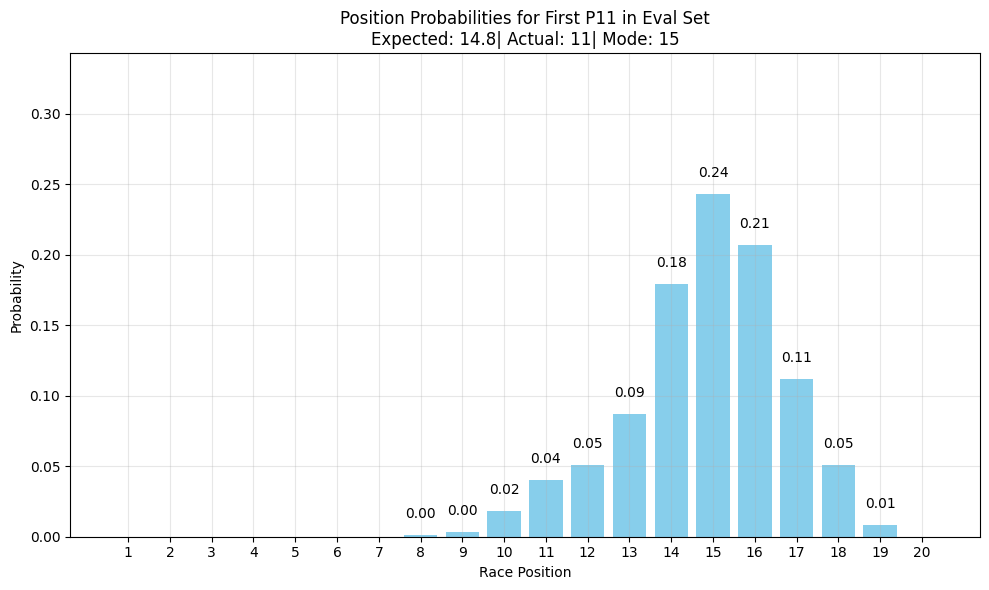

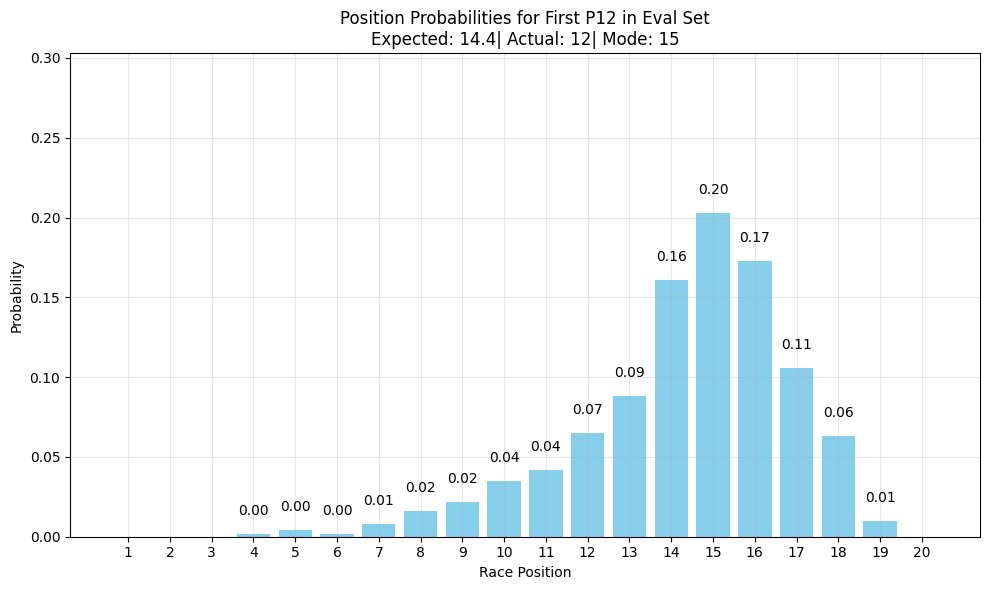

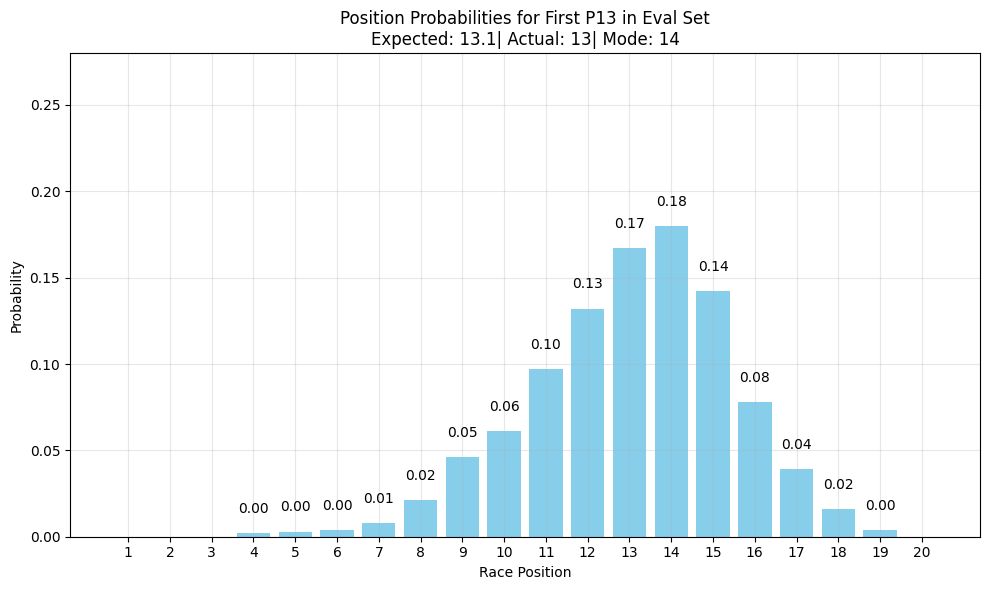

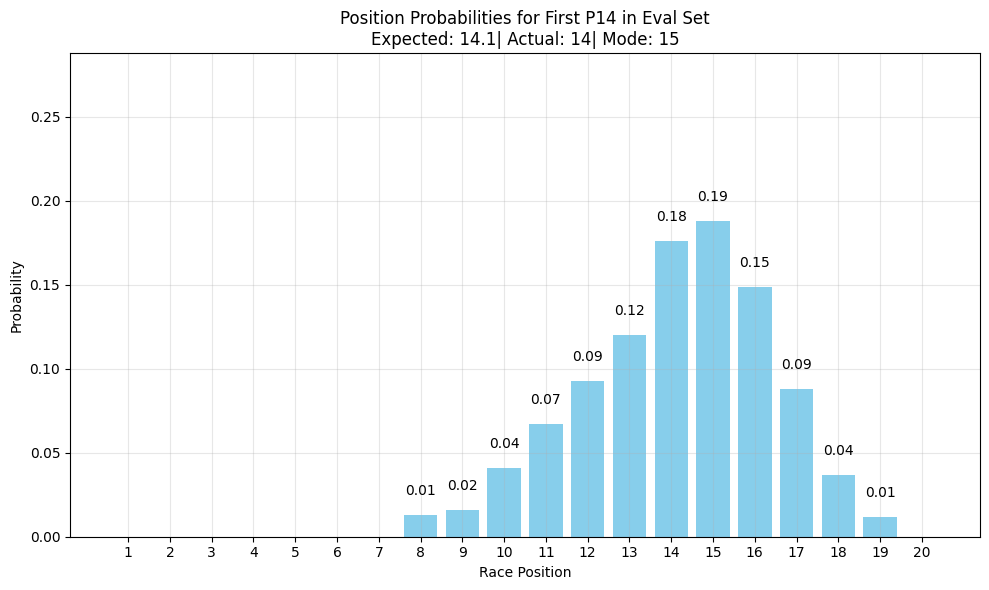

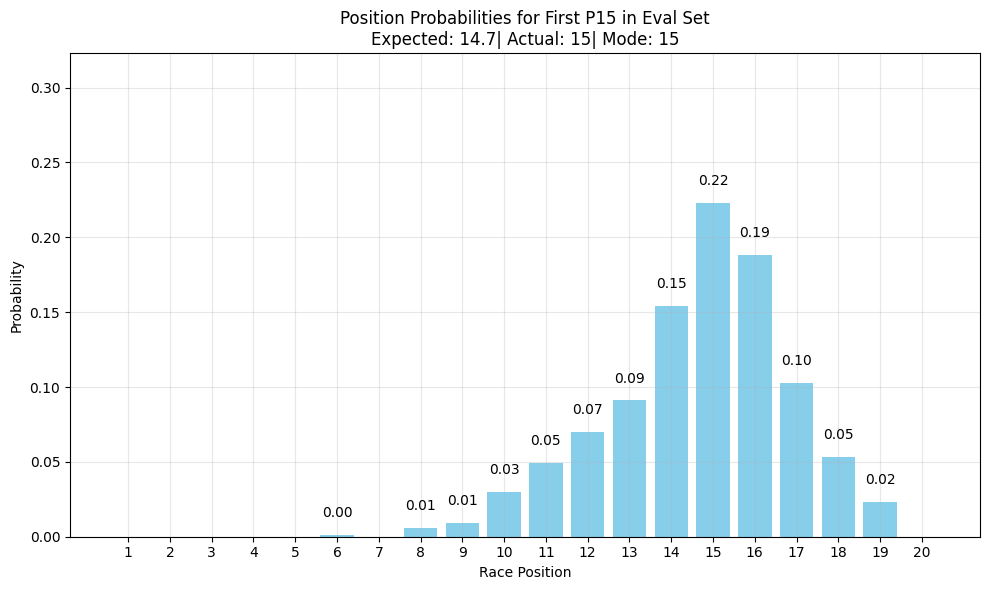

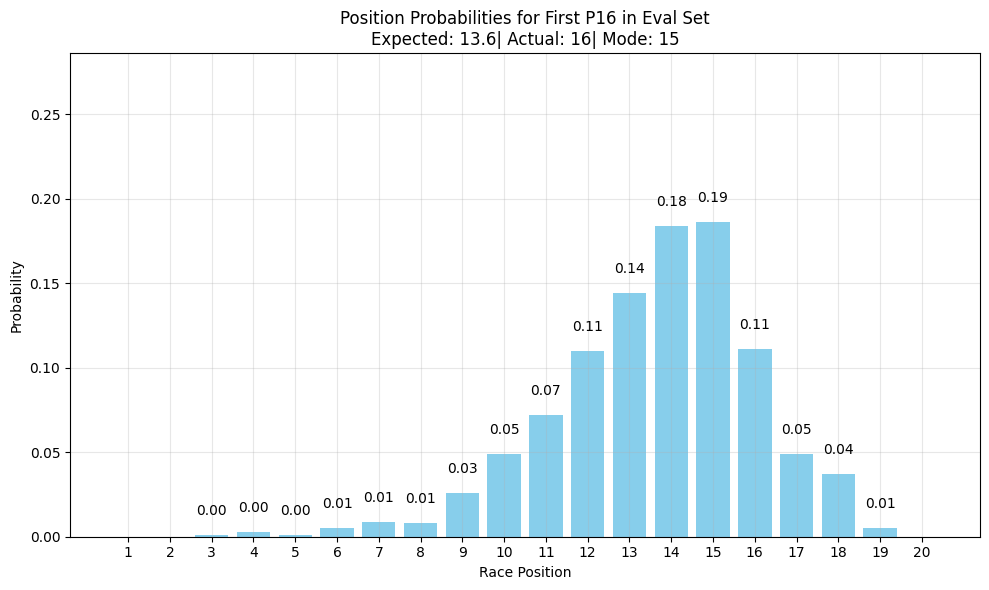

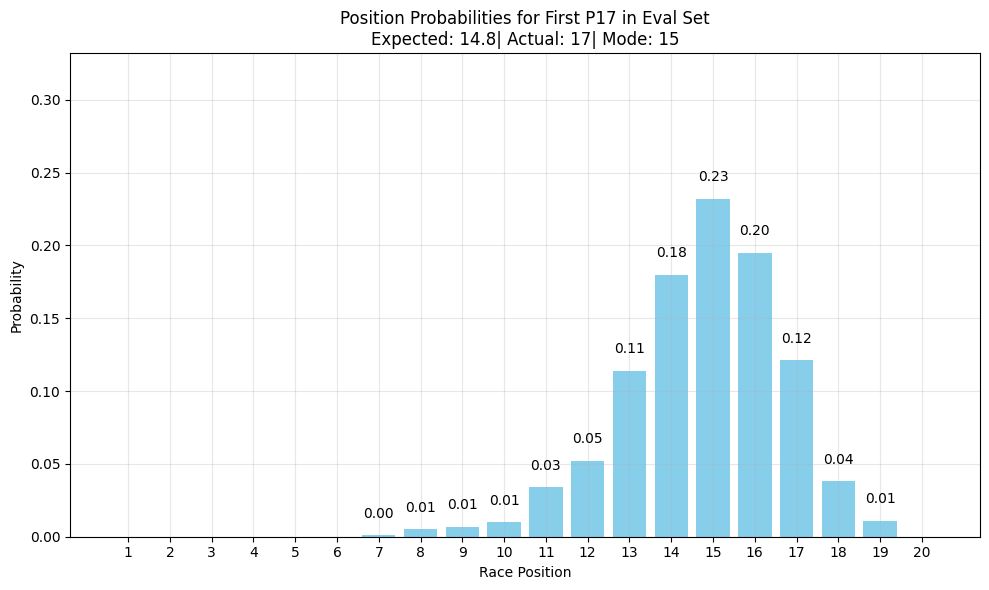

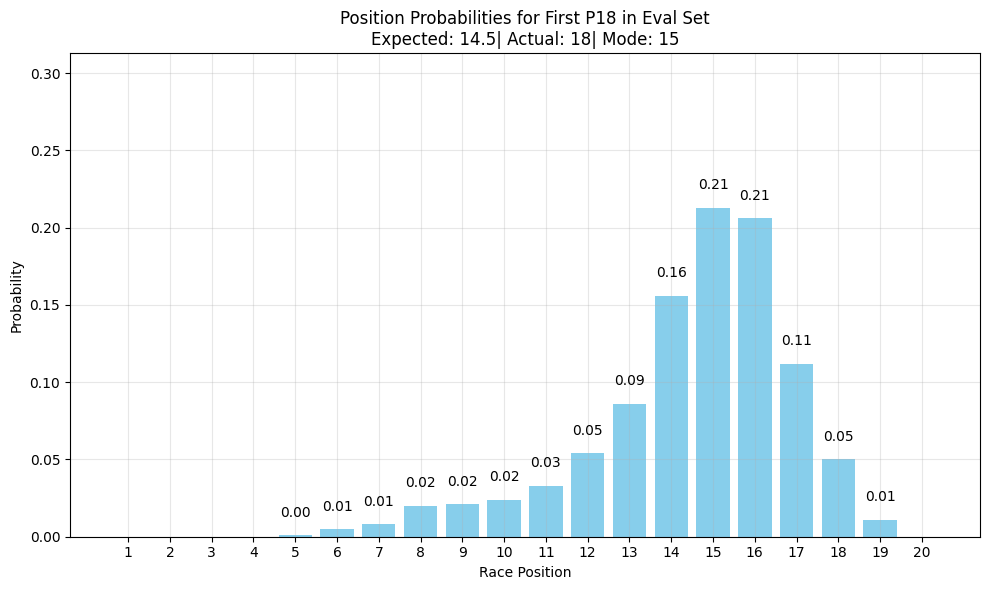

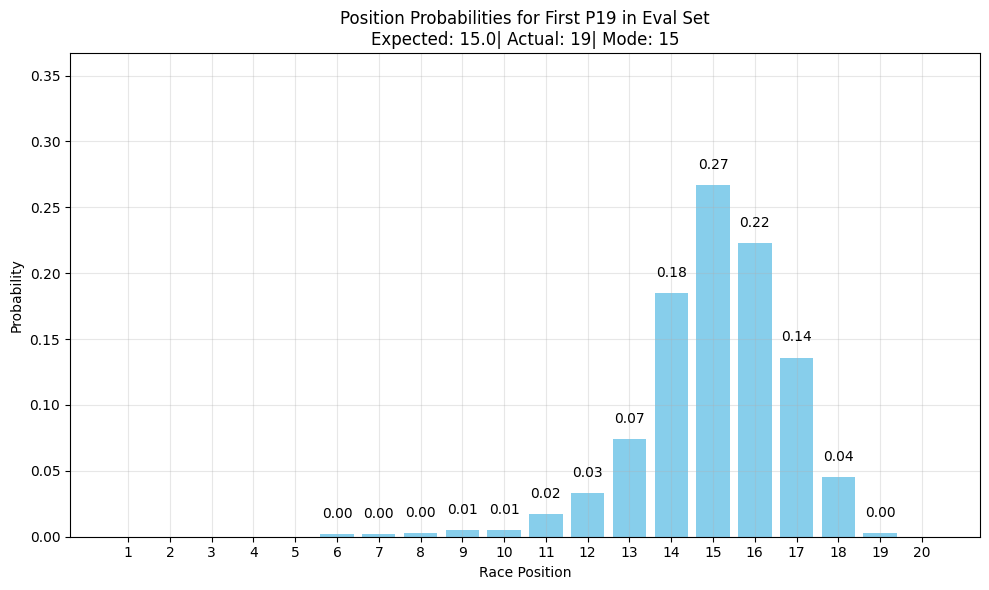

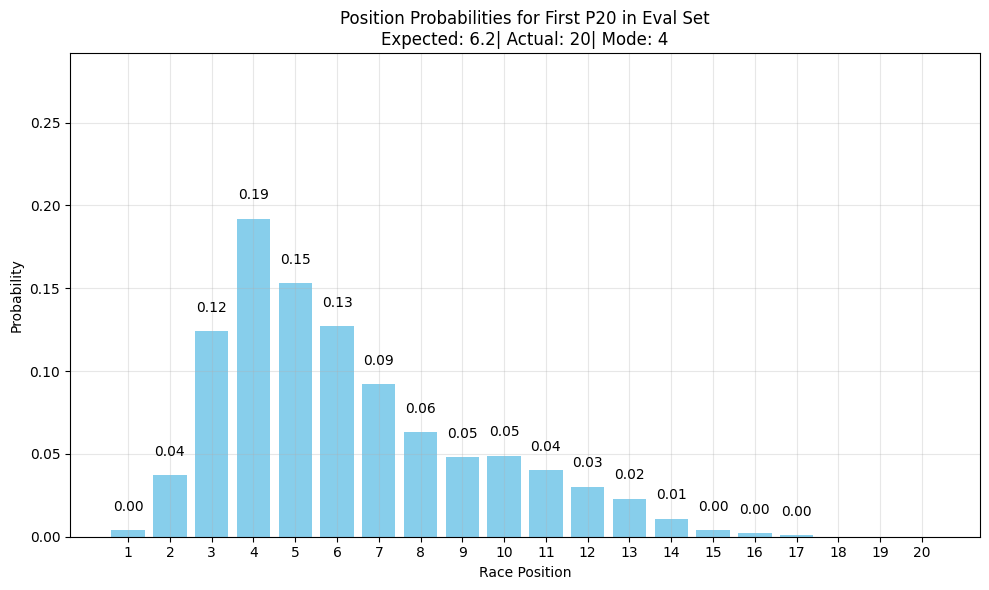

In [12]:
# For each actual position 1-20
for target_position in range(1, 21):
    # Find all instances of this position in evaluation set
    position_mask = y_eval == target_position
    if not any(position_mask):
        print(f"No examples found for P{target_position}")
        continue
        
    position_index = y_eval[position_mask].index[0]
    sample_data = X_eval.loc[[position_index]]
    actual_position = y_eval.loc[position_index]
    
    # Get the predicted value for this sample
    sample_prediction = best_rf_model.predict(sample_data)[0]
    
    # Get predictions from each tree
    tree_predictions = [tree.predict(sample_data.values)[0] for tree in best_rf_model.estimators_]
    
    # Round and clip predictions
    tree_positions = np.clip(np.round(tree_predictions), 1, 20).astype(int)
    
    # Compute probabilities
    positions = np.arange(1, 21)
    counts = np.bincount(tree_positions, minlength=21)[1:21]
    probabilities = counts / len(tree_predictions)
    
    # Create new figure for each position
    plt.figure(figsize=(10, 6))
    plt.bar(positions, probabilities, color='skyblue')
    plt.xlabel("Race Position")
    plt.ylabel("Probability")
    plt.title(f"Position Probabilities for First P{target_position} in Eval Set\nExpected: {sample_prediction:.1f}| Actual: {actual_position:.0f}| Mode: {positions[np.argmax(probabilities)]}")
    plt.xticks(positions)
    
    # Annotate probabilities
    for pos, prob in zip(positions, probabilities):
        if prob > 0:
            plt.text(pos, prob + 0.01, f"{prob:.2f}", ha='center', va='bottom')
    
    plt.ylim(0, max(probabilities) + 0.1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Expected  value is the average, and doesn't reflect the most likely position (the mode)

In [13]:
actual_positions = []
expected_predictions = []
mode_predictions = []

for target_position in range(1, 21):
    # Find a sample for this position in evaluation set
    position_mask = y_eval == target_position
    if not any(position_mask):
        continue

    position_index = y_eval[position_mask].index[0]
    sample_data = X_eval.loc[[position_index]]
    
    # Actual Race position
    actual = y_eval.loc[position_index]
    
    # Expected prediction from the overall model (the average prediction)
    expected = best_rf_model.predict(sample_data)[0]
    
    # Get predictions from each tree and derive the mode prediction
    tree_preds = [tree.predict(sample_data.values)[0] for tree in best_rf_model.estimators_]
    tree_positions = np.clip(np.round(tree_preds), 1, 20).astype(int)
    positions = np.arange(1, 21)
    counts = np.bincount(tree_positions, minlength=21)[1:21]
    probabilities = counts / len(tree_preds)
    mode_prediction = positions[np.argmax(probabilities)]
    
    # Append to lists for later error calculation
    actual_positions.append(actual)
    expected_predictions.append(expected)
    mode_predictions.append(mode_prediction)

# Convert lists to NumPy arrays for metric calculations
actual_array = np.array(actual_positions)
expected_array = np.array(expected_predictions)
mode_array = np.array(mode_predictions)

# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for the expected predictions
mae_expected = np.mean(np.abs(actual_array - expected_array))
rmse_expected = np.sqrt(np.mean((actual_array - expected_array) ** 2))

# Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) for the mode predictions
mae_mode = np.mean(np.abs(actual_array - mode_array))
rmse_mode = np.sqrt(np.mean((actual_array - mode_array) ** 2))

print("Error Metrics based on Expected Predictions:")
print(f"MAE: {mae_expected:.2f}")
print(f"RMSE: {rmse_expected:.2f}")

print("\nError Metrics based on Mode of Tree Predictions:")
print(f"MAE: {mae_mode:.2f}")
print(f"RMSE: {rmse_mode:.2f}")

# Using the mode increases the discrepancy in the regression values

Error Metrics based on Expected Predictions:
MAE: 3.36
RMSE: 4.48

Error Metrics based on Mode of Tree Predictions:
MAE: 3.60
RMSE: 5.03
